## Определение перспективного тарифа для телеком компании
<a href='#section1'>1. Изучение общей информации, приведение данных к нужным типам, исправление ошибок</a>

<a href='#section2'>2. Подготовка таблиц для расчётов</a>

<a href='#section3'>3. Расчёты по месяцам для каждого пользователя</a>

<a href='#section4'>4. Анализ данных</a>

<a href='#section5'>5. Гистограммы</a>

<a href='#section6'>6. Проверка гипотез</a>

<a href='#section7'>7. Общий вывод</a>

<a id='section1'></a>
### 1. Изучение общей информации, приведение данных к нужным типам, исправление ошибок

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
df_calls = pd.read_csv('/datasets/calls.csv')
df_calls.info()
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_calls['duration'] = df_calls['duration'].apply(np.ceil).astype('int')
print()
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


Пропущенных данных в звонках нет, дату перевела в тип datetime, длительность звонка округлила до минут в большую сторону и перевела в int. В таблице есть звонки с длительностью 0.0, скорее всего это пропущенные звонки или когда у абонента выключен телефон. Их обработка влияет только на количество сделанных звонков, а на дальнейшие расчёты и выгодность тарифов не влияет. Поэтому я не стала удалять эти строки.

In [2]:
df_messages = pd.read_csv('/datasets/messages.csv')
df_messages.info()
print()
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Пропущенных данных в сообщениях нет, дату перевела в тип datetime.

In [3]:
df_internet = pd.read_csv('/datasets/internet.csv')
df_internet.info()
print()
df_internet.columns = ['id', 'session_id', 'mb_used', 'session_date', 'user_id']
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_internet = df_internet.loc[df_internet.loc[:, 'mb_used'] != 0.00]
df_internet['mb_used'] = df_internet['mb_used'].apply(np.ceil).astype('int')
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 5 columns):
id              129798 non-null int64
session_id      129798 non-null object
mb_used         129798 non-null int64
session_date    129798 non-null datetime64[ns]
user_id         129798 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.9+ MB


Пропущенных данных в таблице использования интернета нет, дату перевела в тип datetime, мегабайты округлила до целого в большую сторону и перевела в int. Переименовала пустую колонку в id, а id в session_id. Удалила строки, где потраченные мегабайты равны 0, видимо, человек подключился к интернету, но ничего не потратил.

In [4]:
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_tariffs.info()
df_tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В тарифах все данные верные. 

In [5]:
df_users = pd.read_csv('/datasets/users.csv')
df_users.info()
print()
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


В таблице пользователей даты привела к типу datetime64. Пропущенные значения в колонке churn_date не заполняла.

<a id='section2'></a>
### 2. Подготовка таблиц для расчётов

In [6]:
df_calls['month'] = df_calls['call_date'].dt.month
calls = df_calls.pivot_table(index = 'user_id',
                         columns='month',
                         values='duration',
                         aggfunc = ['sum', 'count'],
                         fill_value=0)
calls.columns =[s1 + str(s2) for (s1,s2) in calls.columns.tolist()]
calls.reset_index(inplace=True)
calls.reset_index(inplace=True)

df_messages['month'] = df_messages['message_date'].dt.month
messages = df_messages.pivot_table(index = 'user_id',
                         columns='month',                         
                         values='message_date',
                         aggfunc = 'count',
                         fill_value=0)
messages.columns =['count' + str(s) for s in messages.columns.tolist()]
messages.reset_index(inplace=True)

df_internet['month'] = df_internet['session_date'].dt.month
internet = df_internet.pivot_table(index = 'user_id',
                         columns='month',                         
                         values='mb_used',
                         aggfunc = 'sum',
                         fill_value=0)
internet.columns =['sum' + str(s) for s in internet.columns.tolist()]
internet.reset_index(inplace=True)

Сводные таблицы для расчётов количества сделанных звонков, израсходованных минут разговора, мегабайт интернета и отправленных сообщений. В таблицы звонков, сообщений и мегабайт добавила колонки с номером месяца для того, чтобы применить к ним функцию pivot_table. Отсутствующие значения заменила на 0. Колонкам дала названия sum и count с номером месяца.

<a id='section3'></a>
### 3. Расчёты по месяцам для каждого пользователя

In [7]:
arr = []
for el in df_users['user_id']:
    # строка с данными пользователя
    user = df_users.loc[df_users['user_id'] == el] 
    # месяцы использования тарифа
    start = user['reg_date'].dt.month.values[0]
    end = user['churn_date'].dt.month.values[0]
    end = 12 if np.isnan(end) else end  
    city = user['city'].values[0]
    # данные по тарифу пользователя
    tariff = user['tariff'].values[0] 
    tariff = df_tariffs.query('tariff_name == @tariff')
    tariff_name = tariff['tariff_name'].values[0]
    total = tariff['rub_monthly_fee'].values[0]
    tariff_minutes = tariff['minutes_included'].values[0]
    tariff_messages = tariff['messages_included'].values[0]
    tariff_mb = tariff['mb_per_month_included'].values[0]
    price_minute = tariff['rub_per_minute'].values[0]
    price_message = tariff['rub_per_message'].values[0]
    price_gb = tariff['rub_per_gb'].values[0]
    # строки из сводных таблиц для этого пользователя
    c = calls.loc[calls['user_id'] == el]
    m = messages.loc[messages['user_id'] == el]
    n = internet.loc[internet['user_id'] == el]
    l = len(c.index)
    for j in range(1, 13):
        if start <= j <= end:
            s = str(j)          
            calls_sum = 0 if (l == 0) else c['sum' + s].values[0]   
            calls_count = 0 if (l == 0) else c['count' + s].values[0]
            messages_count = 0 if (len(m.index) == 0) else m['count' + s].values[0]    
            internet_sum = 0 if (len(n.index) == 0) else n['sum' + s].values[0]  
        
            if calls_sum > tariff_minutes:
                total += (calls_sum - tariff_minutes) * price_minute
            
            if messages_count > tariff_messages:
                total += (messages_count - tariff_messages) * price_message
            
            if internet_sum > tariff_mb:
                total += np.ceil((internet_sum - tariff_mb) / 1024) * price_gb

            arr.append([el, j, calls_count, calls_sum, messages_count, internet_sum, total, tariff_name, city])

df = pd.DataFrame(arr, columns = ['user_id','month','calls','minutes','messages','internet','total','tariff','city'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 9 columns):
user_id     3216 non-null int64
month       3216 non-null int64
calls       3216 non-null int64
minutes     3216 non-null int64
messages    3216 non-null int64
internet    3216 non-null int64
total       3216 non-null float64
tariff      3216 non-null object
city        3216 non-null object
dtypes: float64(1), int64(6), object(2)
memory usage: 226.2+ KB


In [8]:
c = df_calls.pivot_table(index = ['user_id', 'month'],
                       values='duration',
                       aggfunc = ['sum', 'count'],
                       fill_value=0).reset_index()
    
m = df_messages.pivot_table(index = ['user_id', 'month'],
                       values='message_date',
                       aggfunc = ['count'],
                       fill_value=0).reset_index()
    
i = df_internet.pivot_table(index = ['user_id', 'month'],
                       values='mb_used',
                       aggfunc = ['sum'],
                       fill_value=0).reset_index()


new_df = c.merge(m, on = ['user_id', 'month']).reset_index()

new_df = new_df.merge(i, on = ['user_id', 'month']).reset_index()
new_df.columns =['index1', 'index2', 'user_id','month','minutes','calls','messages','internet']
del new_df['index1']
del new_df['index2']

def plus(str):
    user_id = str['user_id']
    user = df_users.loc[df_users['user_id'] == user_id] 
    tariff = user['tariff'].values[0] 
    tariff = df_tariffs.query('tariff_name == @tariff')
    tariff_name = tariff['tariff_name'].values[0]
    total = tariff['rub_monthly_fee'].values[0]
    tariff_minutes = tariff['minutes_included'].values[0]
    tariff_messages = tariff['messages_included'].values[0]
    tariff_mb = tariff['mb_per_month_included'].values[0]
    price_minute = tariff['rub_per_minute'].values[0]
    price_message = tariff['rub_per_message'].values[0]
    price_gb = tariff['rub_per_gb'].values[0]
    if str['minutes'] > tariff_minutes:
        total += (str['minutes'] - tariff_minutes) * price_minute
            
    if str['messages'] > tariff_messages:
        total += (str['messages'] - tariff_messages) * price_message
            
    if str['internet'] > tariff_mb:
        total += np.ceil((str['internet'] - tariff_mb) / 1024) * price_gb
        
    return total
    
    
new_df['total'] = new_df.apply(plus, axis = 1)
new_df.info()

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 7 columns):
user_id     2665 non-null int64
month       2665 non-null int64
minutes     2665 non-null int64
calls       2665 non-null int64
messages    2665 non-null int64
internet    2665 non-null int64
total       2665 non-null float64
dtypes: float64(1), int64(6)
memory usage: 145.9 KB


Заполняю таблицу по месяцам для каждого пользователя.

    • calls - количество сделанных звонков;
    
    • minutes - количество израсходованных минут разговора;
    
    • messages - количество отправленных сообщений;
    
    • internet - объем израсходованного интернет-трафика в мегабайтах;
    
    • total - выручка; 
    
<a id='section4'></a>
### 4. Анализ данных

In [9]:
smart = df.loc[df['tariff'] == 'smart']
s_messages = smart['messages']
s_minutes = smart['minutes']
s_internet = smart['internet']
ultra = df.loc[df['tariff'] == 'ultra']
u_messages = ultra['messages']
u_minutes = ultra['minutes']
u_internet = ultra['internet']

table = [
    ['Сообщения', s_messages.mean(), u_messages.mean()],
    ['Минуты', s_minutes.mean(), u_minutes.mean()],
    ['Интернет, Мб', s_internet.mean(), u_internet.mean()],
    ['Дисперсия по сообщениям', np.var(s_messages), np.var(u_messages)],
    ['Дисперсия по минутам', np.var(s_minutes), np.var(u_minutes)],
    ['Дисперсия по интернету', np.var(s_internet), np.var(u_internet)],
    ['Стандартное отклонение по сообщениям', np.std(s_messages, ddof = 1), np.std(u_messages, ddof = 1)],
    ['Стандартное отклонение по минутам', np.std(s_minutes, ddof = 1), np.std(u_minutes, ddof = 1)],
    ['Стандартное отклонение по интернету', np.std(s_internet, ddof = 1), np.std(u_internet, ddof = 1)]
]

result = pd.DataFrame(table, columns = ['','Смарт','Ультра'])
result['Смарт'] = result['Смарт'].apply(np.round).astype('int')
result['Ультра'] = result['Ультра'].apply(np.round).astype('int')
result

,,Смарт,Ультра
0,Сообщения,33,49
1,Минуты,418,526
2,"Интернет, Мб",16222,19467
3,Дисперсия по сообщениям,797,2283
4,Дисперсия по минутам,36265,100950
5,Дисперсия по интернету,34632986,102113596
6,Стандартное отклонение по сообщениям,28,48
7,Стандартное отклонение по минутам,190,318
8,Стандартное отклонение по интернету,5886,10110


Пользователям тарифа Смарт в среднем требуется меньше сообщений, минут разговора и интернета. Разница незначительна. Пользователи тарифа Смарт немного превышают тариф по интернету, а в остальном укладываются в абонентскую плату. Пользователи тарифа Ультра в среднем не используют полностью то, что включено в тариф.

<a id='section5'></a>
### 4. Гистограммы

Тарифы Смарт(синий) и Ультра(оранжевый)


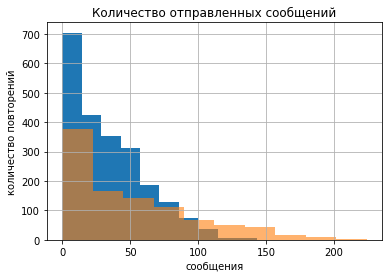

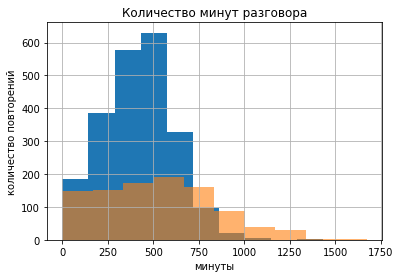

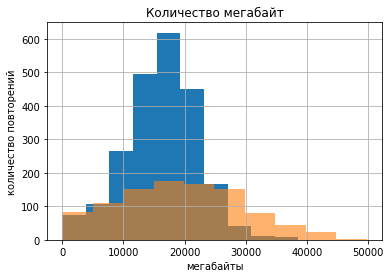

In [10]:
def plot_hist(df1, df2, title, xlabel, ylabel='количество повторений'):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    df1.hist()
    df2.hist(alpha=0.6)
    plt.show()
    
    
print('Тарифы Смарт(синий) и Ультра(оранжевый)')
plot_hist(s_messages, u_messages, 'Количество отправленных сообщений', 'сообщения')
plot_hist(s_minutes, u_minutes, 'Количество минут разговора', 'минуты')
plot_hist(s_internet, u_internet, 'Количество мегабайт', 'мегабайты')

Распределение использования интернета можно считать нормальным, потому что график относительно среднего в обе стороны примерно одинаковый.

В тарифе Ультра заявленное количество сообщений и минут избыточно: никто столько не тратит, минут разговора тратят максимум чуть больше половины, а сообщений только пятую часть.

Тариф Ультра может быть выгоден только людям, которые очень много пользуются интернетом.

<a id='section6'></a>
### 6. Проверка гипотез

In [11]:
smart_total = smart['total']
ultra_total = ultra['total']
print('Дисперсия выручки по тарифам:')
print('Смарт - ', int(np.var(smart_total)))
print('Ультра - ', int(np.var(ultra_total)))
print()

alpha = 0.05 # критический уровень статистической значимости
results = st.ttest_ind(smart_total, ultra_total)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")   

Дисперсия выручки по тарифам:
Смарт -  11353266
Ультра -  1734097

Отвергаем нулевую гипотезу


   • Нулевая гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» равны;
    
   • Альтернативная гипотеза - средняя выручка пользователей тарифов «Ультра» и «Смарт» отличаются;

In [12]:
moscow = df.loc[df['city'] == 'Москва']['total']
other = df.loc[df['city'] != 'Москва']['total']
print('Дисперсия выручки по тарифам:')
print('Москва - ', int(np.var(moscow)))
print('Другие регионы - ', int(np.var(other)))
print()
results = st.ttest_ind(moscow, other)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Дисперсия выручки по тарифам:
Москва -  6655178
Другие регионы -  9129501

Не получилось отвергнуть нулевую гипотезу


   • Нулевая гипотеза - средняя выручка пользователей из Москвы равна выручке пользователей из других регионов
 
   • Альтернативная гипотеза - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

<a id='section7'></a>
### 7. Общий вывод

В процессе предобработки заменили некоторые типы данных. Удалили строки из таблицы с интернет-трафиком, где потраченные мегабайты равны 0.

Была составлена таблица для каждого пользователя по месяцам с количеством сделанных звонков и израсходованных минут разговора, отправленных сообщений, объемом израсходованного интернет-трафика, а также выручку с каждого пользователя.

Тариф Ультра для оператора более выгоден по расчётам средних значений по выборке, а также гипотеза о равенсве выручки не подтвердилась.

В результате проверки гипотез получилось, что средняя выручка пользователей тарифов «Ультра» и «Смарт» отличаются, а средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.